In [30]:
import itertools
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from utils import FundamentalData, delta, rank, alpha_example_1, alpha_example_2, alpha_example_4, alpha_example_3


In [31]:
class FinancialDataProcessor:
    def __init__(self, dates_file, stocks_file, data_file, alpha_function):
        self.fundamental_data = FundamentalData(dates_file, stocks_file, data_file)
        self.alpha_function = alpha_function
        self.dates = self.fundamental_data.date_df
        self.stocks = self.fundamental_data.stocks_df
        self.data = self.fundamental_data.data.to_dataframe()
        self.weight_matrix = np.zeros((len(self.dates), len(self.stocks)))
        self.normalized_weight_matrix = None
        self.pnl_matrix = np.zeros((len(self.dates), len(self.stocks)))
        self.cumulative_pnl_matrix = np.zeros((len(self.dates), len(self.stocks)))


    def calculate_weights(self):
        alpha_values = self.alpha_function(self.fundamental_data)
        for i, j in itertools.product(range(len(self.dates)), range(len(self.stocks))):
            self.weight_matrix[i, j] = alpha_values.loc[self.dates['date'][i], self.stocks['Symbol'][j]]

        weights = self.weight_matrix.flatten()
        normalized_weights = weights - np.mean(weights)
        total_abs_sum = np.sum(np.abs(normalized_weights))
        adjustment_factor = 250 / total_abs_sum
        adjusted_weights = normalized_weights * adjustment_factor
        self.normalized_weight_matrix = adjusted_weights.reshape(self.weight_matrix.shape)
        print(self.normalized_weight_matrix)

    # def calculate_pnl(self):
    #     for i, j in itertools.product(range(len(self.dates)), range(len(self.stocks))):
    #         self.pnl_matrix[i, j] = (self.data.at[(self.dates['date'][i], self.stocks['Symbol'][j]), 'close'] - 
    #                                  self.data.at[(self.dates['date'][i], self.stocks['Symbol'][j]), 'open'])
    #         self.pnl_matrix[i, j] *= self.normalized_weight_matrix[i, j]

    def calculate_pnl(self):
        for i, j in itertools.product(range(len(self.dates)), range(len(self.stocks))):
            daily_pnl = (self.data.at[(self.dates['date'][i], self.stocks['Symbol'][j]), 'close'] - 
                         self.data.at[(self.dates['date'][i], self.stocks['Symbol'][j]), 'open'])
            daily_pnl *= self.normalized_weight_matrix[i, j]
            self.pnl_matrix[i, j] = daily_pnl

        for i in range(len(self.dates)):
            if i == 0:
                self.cumulative_pnl_matrix[i, :] = self.pnl_matrix[i, :]
            else:
                self.cumulative_pnl_matrix[i, :] = self.cumulative_pnl_matrix[i-1, :] + self.pnl_matrix[i, :]
        print(self.pnl_matrix)
        return self.cumulative_pnl_matrix

    def plot_daily_pnl(self):
        pnl_df = pd.DataFrame(self.pnl_matrix, index=self.dates['date'], columns=self.stocks['Symbol'])
        daily_pnl = pnl_df.sum(axis=1)
        daily_pnl.plot()
        plt.xlabel('Date')
        plt.ylabel('PnL')
        plt.show()

    def plot_cumulative_pnl(self):
        cumulative_pnl_df = pd.DataFrame(self.cumulative_pnl_matrix, index=self.dates['date'], columns=self.stocks['Symbol'])
        cumulative_pnl = cumulative_pnl_df.sum(axis=1)
        cumulative_pnl.plot()
        plt.xlabel('Date')
        plt.ylabel('Cumulative PnL')
        plt.title('Cumulative PnL Over Time')
        plt.show()

/var/folders/22/4w96t86s5f3_vj4kp3hnq_ph0000gn/T/ipykernel_10379/4133449171.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.weight_matrix[i, j] = alpha_values.loc[self.dates['date'][i], self.stocks['Symbol'][j]]


[[-0.06042967  0.1726228  -0.02927364 -0.06479277]
 [-0.06042967  0.1726228  -0.02927364 -0.06479277]
 [-0.06042967  0.1726228  -0.02927364 -0.06479277]
 ...
 [-0.06383014  0.01029622 -0.05354319 -0.03199182]
 [-0.06383014  0.01029622 -0.05354319 -0.03199182]
 [-0.06383014  0.01029622 -0.05354319 -0.03199182]]
[[-2.48668095e+00 -1.83394460e+02  6.70659187e+00  1.43839957e+00]
 [-2.85228045e+00 -4.02556363e+01 -7.68579526e+00 -4.27308340e+00]
 [-3.10910655e+00 -1.75445180e+02  1.02896859e+00 -1.03020510e+00]
 ...
 [ 3.92555365e-01 -3.99081486e+00 -7.76376185e-01  4.81476899e-01]
 [ 4.56385506e-01 -1.44455966e+00  1.39212281e-01  3.03922295e-02]
 [ 2.29788506e-01 -3.44511520e+00 -8.16533574e-01  4.47885488e-01]]


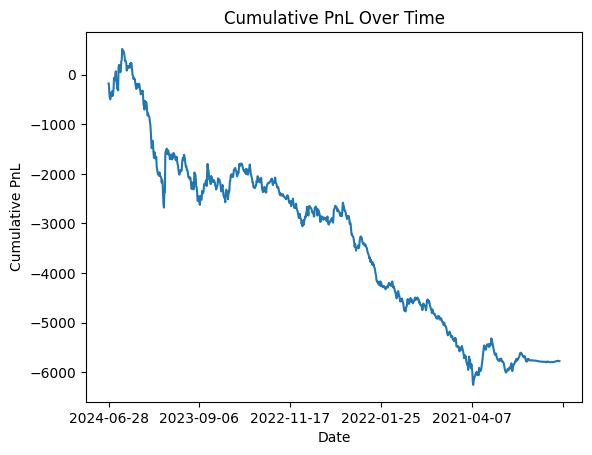

In [32]:
processor = FinancialDataProcessor('date.csv', 'ind_nifty500list.csv', 'my_3d_dataarray.nc', alpha_example_1)
processor.calculate_weights()
processor.calculate_pnl()
processor.plot_cumulative_pnl()